In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [17]:
# setup latex formatting
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif', size=28)
rc('axes', labelsize=28)

## Inputs

In [18]:
MAX_DIM = 512  # limit images to MAX_DIM x MAX_DIM resolution
MAX_RGB = 255  # maximum RGB intensize

VGG19_INPUT_SHAPE = (224, 224)  # shape of input taken by VV19

content_path = 'images/in/sybil.jpg'  # location of content image
style_path = 'images/in/cezanne_style.jpg'  # location of style image

# for matching features in generated image to content and style images
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

## Preprocessing

In [19]:
def load_img(img_path):
    """ Load image from path into tensor object.
    
    Load image from the specified path into a tensor and resize to
    safely propagate through network.
    
    Args:
        img_path (str): path to image
        
    Returns:
        img (tf.Tensor): tensor representing image with max size
            (1, MAX_DIM, MAX_DIM, 3)
    """
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # determine scaling to reduce to MAX_DIM
    orig_shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(orig_shape)
    scale = MAX_DIM / long_dim
    # cast into new shape ()
    new_shape = tf.cast(orig_shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]

    return img

In [20]:
def plot_img(ax, img, title=None):
    """ Plot image nicely
    
    Args:
        ax (matplotlib.pyplot.axis): axis to plot image on
        img (tf.Tensor): tensor representing image
        title (str): title for image
    """
    # plot
    img = tf.squeeze(img, axis=0)
    ax.imshow(img)
    # format
    ax.axis('off')
    if title is not None:
        ax.set_title(title)

In [21]:
def load_and_show_content_and_style(content_path, style_path):
    """ Load and display the content and style images
    
    Args:
        content_path (str): path to content image
        style_path (str): path to style image
        
    Returns:
        content_img (numpy.ndarry): RGB array for content image
        style_img (numpy.ndarry): RGB array for style image
    """
    # load
    content_img = load_img(content_path)
    style_img = load_img(style_path)
    # plot
    fig, axs = plt.subplots(1, 2, figsize=(18,9))
    plot_img(axs[0], content_img, 'Content Image')
    plot_img(axs[1], style_img, 'Style Image')
    # format
    fig.tight_layout()
    
    return (content_img, style_img)

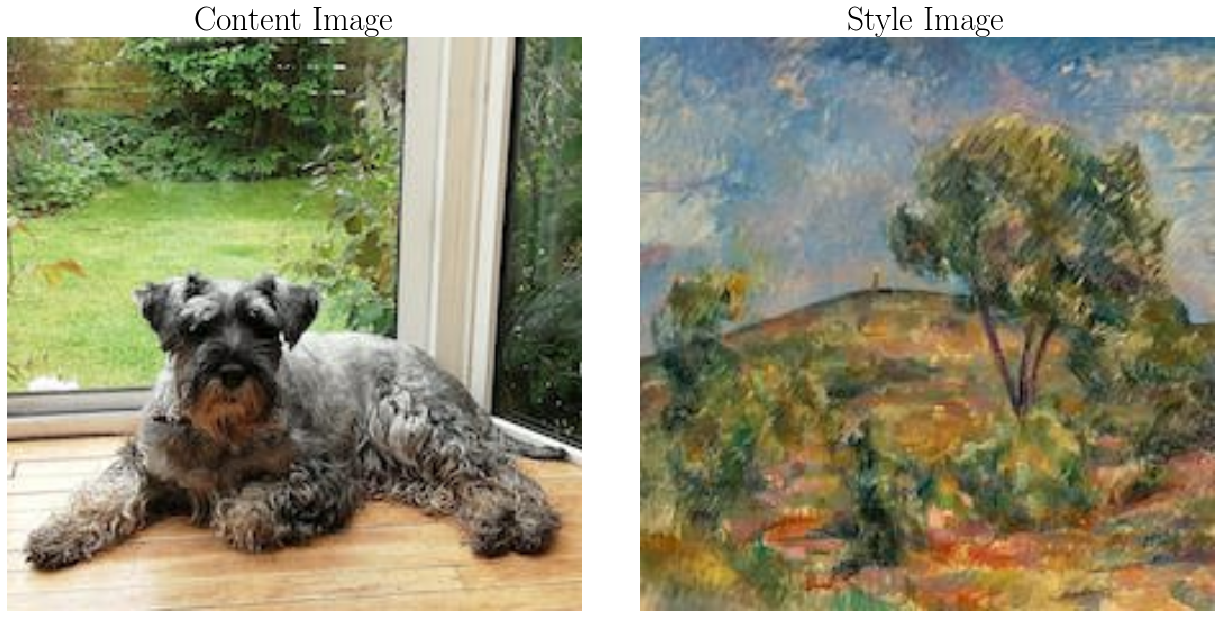

In [22]:
content_img, style_img = load_and_show_content_and_style(content_path, style_path)

## Load pre-trained neural network

In [11]:
# include_top=False -> no classification layer
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

In [24]:
def vgg_intermediate_output(layer_names):
    """ Create pretrained VGG model with intermediate outputs.
    
    Load the pretrained VGG network and construct a model which outputs
    from intermediate layers.
    
    Args:
        layer_names (list): list of layer names to output from.
        
    Returns:
        model (tf.keras.Model): the corresponding model
    """
    # include_top=False -> no classification layer
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [25]:
style_model = vgg_intermediate_output(style_layers)
style_outputs = style_model(style_img*MAX_RGB)

In [44]:
def gram_matrix(input_tensor):
    """ Compute the normalised Gram matrix.
    
    Takes a batch (b) of matrices with and computes the Gram matrix for each.
    
    Args:
        input_tensor (tf.Tensor): Tensor containing batch of matrices.
    """
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    n_elems = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/n_elems

In [45]:
class StyleContentModel(tf.keras.models.Model):
    """ A model which returns the style and content tensors of an image.
    """
    def __init__(self, style_laters, content_layers):
        """ Create pretrained VGG model with intermediate layer outputs.
        
        Args:
            style_layers (list): Names of intermediate VGG layers to 
                extract style outputs from.
            content_layers (list): Names of intermediate VGG layers to 
                extract content outputs from.
        """
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_intermediate_output(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        """ Extract the content and style outputs for a given input.
        
        Given an image, preprocess and pass to the pretrained VGG19 network. 
        Extract and neatly package the style and content outputs.
        
        Args:
            inputs (tf.Tensor): (Batch of) Input image(s) with pixel values in
                range (0,1).
        
        Returns:
            cache (dict): Neatly packaged cache of style and content outputs.
        """
        inputs = inputs*MAX_RGB
        preprocessed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_inputs)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]
        
        content_dict = {content_name : value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name : value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
        
        cache = {'content' : content_dict, 'style' : style_dict} 
        return cache

In [46]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_img))

In [47]:
def print_results_dict(results, key):
    print(key+':')
    for name, output in sorted(results[key].items()):
        print("\t", name)
        print("\t\tshape: ", output.numpy().shape)
        print("\t\t  min: ", output.numpy().min())
        print("\t\t  max: ", output.numpy().max())
        print("\t\t mean: ", output.numpy().mean())
        print()

In [48]:
print_results_dict(results, 'content')
print_results_dict(results, 'style')

content:
	 block5_conv2
		shape:  (1, 32, 32, 512)
		  min:  0.0
		  max:  896.86597
		 mean:  13.077307

style:
	 block1_conv1
		shape:  (1, 64, 64)
		  min:  0.014326714
		  max:  29341.129
		 mean:  324.63885

	 block2_conv1
		shape:  (1, 128, 128)
		  min:  0.0
		  max:  55622.395
		 mean:  11151.153

	 block3_conv1
		shape:  (1, 256, 256)
		  min:  0.0
		  max:  245994.48
		 mean:  10395.4

	 block4_conv1
		shape:  (1, 512, 512)
		  min:  0.0
		  max:  2452073.5
		 mean:  162539.12

	 block5_conv1
		shape:  (1, 512, 512)
		  min:  0.0
		  max:  54569.492
		 mean:  1182.9053



In [50]:
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

In [52]:
img = tf.Variable(content_img)

In [53]:
def clip(img, lo=0., hi=1.):
    return tf.clip_by_value(img, clip_value_min=lo, clip_value_max=hi)

In [54]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [59]:
def style_content_loss(outputs, style_weight=1e-2, content_weight=1e4):
    """ Compute the weighted loss of the given outputs.
    """
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_outputs)
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_outputs)
    
    loss = style_loss + content_loss
    return loss

In [71]:
def high_pass_x_y(img):
    x_var = img[:,:,1:,:] - img[:,:,:-1,:]
    y_var = img[:,1:,:,:] - img[:,:-1,:,:]
    return x_var, y_var

def total_variational_loss(img):
    x_deltas, y_deltas = high_pass_x_y(img)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [72]:
@tf.function()
def train_step(img, total_variational_weight=1e8):
    with tf.GradientTape() as tape:
        outputs = extractor(img)
        loss = style_content_loss(outputs)
        loss += total_variational_weight*total_variational_loss(img)
    
        grad = tape.gradient(loss, img)
        opt.apply_gradients([(grad, img)])
        img.assign(clip(img))

In [73]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(img)
        print(".", end='')
    IPython.display.clear_output(wait=True)
    plt.imhow(img.read_value()[0])
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

....................................................................................................

NameError: name 'IPython' is not defined

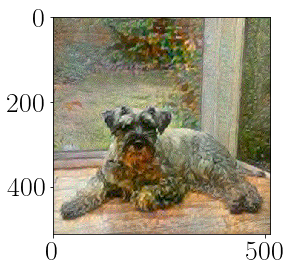

In [74]:
plt.imshow(img.read_value()[0])

Text(0.5, 1.0, 'Combined')

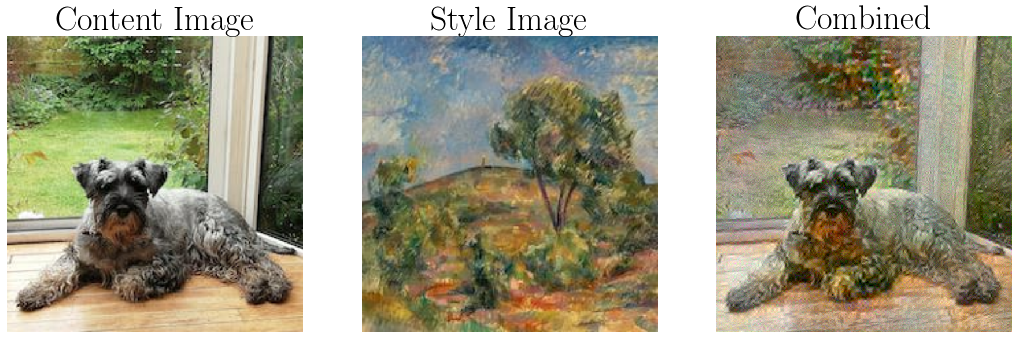

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].imshow(tf.squeeze(content_img, axis=0))
axs[1].imshow(tf.squeeze(style_img, axis=0))
axs[2].imshow(img.read_value()[0])
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[0].set_title('Content Image')
axs[1].set_title('Style Image')
axs[2].set_title('Combined')